## Setup

In [ ]:
!sudo apt-get install -y xvfb ffmpeg x11-utils
!pip install -q 'gym==0.10.11'
!pip install -q 'imageio==2.4.0'
!pip install -q PILLOW
!pip install -q 'pyglet==1.3.2'
!pip install -q pyvirtualdisplay
!pip install -q tf-agents
!pip install colabgymrender
!pip install gym_sokoban
!pip install gym
!apt-get install python-opengl -y
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install piglet
!pip install plotly==4.8
import gym
import gym_sokoban

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

from colabgymrender.recorder import Recorder
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
Display().start()
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import plotly.express as px
import numpy as np

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-agents 0.8.0 requires gym>=0.17.0, but you have gym 0.10.11 which is incompatible.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filepath = r"drive/My Drive/Colab Notebooks/ReinforcementLearning/sokoban_models/"

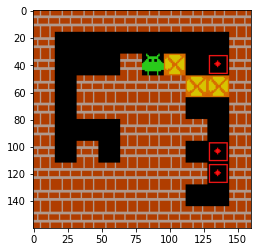

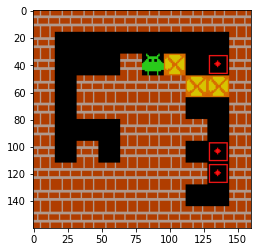

In [ ]:
env = gym.make("PushAndPull-Sokoban-v0")
screen = env.render(mode='rgb_array')
plt.imshow(screen)
observation = env.reset()
ipythondisplay.clear_output(wait=True)
ipythondisplay.display(plt.gcf())

In [ ]:
print(observation.shape)

(160, 160, 3)


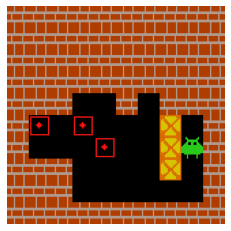

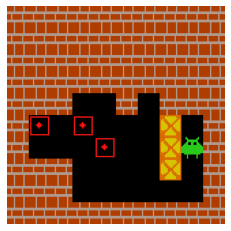

In [ ]:
import sys
import gym
import gym_sokoban
import pylab
import numpy as np
from keras.layers import Dense, Conv2D, LeakyReLU, MaxPooling2D, BatchNormalization, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from IPython import display
from pyvirtualdisplay import Display
import matplotlib.pyplot as plt

d = Display()
d.start()

env = gym.make('PushAndPull-Sokoban-v0')
directory = './video'
from colabgymrender.recorder import Recorder
env = Recorder(env, directory, fps = 3)
state = env.reset()

img = plt.imshow(env.render('rgb_array'))
for _ in range(1):
    state, reward, done, info = env.step(env.action_space.sample()) 
    display.clear_output(wait=True)
    img.set_data(env.render('rgb_array'))
    plt.axis('off')
    display.display(plt.gcf())
    if done:
        env.reset()    

In [ ]:
class A2CAgent:
    def __init__(self, state_size, action_size, gamma, actor_lr, critic_lr):
        # if you want to see the learning, then change to True
        self.render = False
        self.load_model = False
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1

        # These are hyper parameters for the Policy Gradient
        self.discount_factor = gamma
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr

        # create model for policy network
        self.actor = self.build_actor()
        self.critic = self.build_critic()

        if self.load_model:
            self.actor.load_weights("./video/cartpole_actor.h5")
            self.critic.load_weights("./video/cartpole_critic.h5")

    # approximate policy and value using Neural Network
    # actor: state is input and probability of each action is output of model
    def build_actor(self):
        actor = Sequential()
        actor.add(Conv2D(64, kernel_size=(3, 3), activation=LeakyReLU(), input_shape=(self.state_size,self.state_size,3), padding="same", kernel_initializer='glorot_uniform'))
        actor.add(MaxPooling2D(pool_size=(2, 2)))
        actor.add(BatchNormalization())
        actor.add(Conv2D(128, (3, 3), activation=LeakyReLU(), padding="same"))
        actor.add(MaxPooling2D(pool_size=(2, 2)))
        actor.add(BatchNormalization())
        actor.add(Flatten())
        actor.add(Dense(24, activation='relu',
                        kernel_initializer='glorot_uniform'))
        actor.add(Dense(self.action_size, activation='softmax',
                        kernel_initializer='glorot_uniform'))
        actor.summary()
        actor.compile(loss='categorical_crossentropy',
                      optimizer=Adam(lr=self.actor_lr))
        return actor

    # critic: state is input and value of state is output of model
    def build_critic(self):
        critic = Sequential()
        critic.add(Conv2D(64, kernel_size=(3, 3), activation=LeakyReLU(), input_shape=(self.state_size,self.state_size,3), padding="same", kernel_initializer='glorot_uniform'))
        critic.add(MaxPooling2D(pool_size=(2, 2)))
        critic.add(BatchNormalization())
        critic.add(Conv2D(128, (3, 3), activation=LeakyReLU(), padding="same"))
        critic.add(MaxPooling2D(pool_size=(2, 2)))
        critic.add(BatchNormalization())        
        critic.add(Flatten())
        critic.add(Dense(24, activation='relu',
                         kernel_initializer='glorot_uniform'))
        critic.add(Dense(self.value_size, activation='linear',
                         kernel_initializer='glorot_uniform'))
        critic.summary()
        critic.compile(loss="mse", optimizer=Adam(lr=self.critic_lr))
        return critic

    # using the output of policy network, pick action stochastically
    def get_action(self, state):
        policy = self.actor.predict(state, batch_size=1).flatten()
        choice = np.random.choice(self.action_size, 1, p=policy)[0]
        return choice

    # update policy network every episode
    def train_model(self, state, action, reward, next_state, done):
        target = np.zeros((1, self.value_size))
        advantages = np.zeros((1, self.action_size))

        value = self.critic.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]

        if done:
            advantages[0][action] = reward - value
            target[0][0] = reward
        else:
            advantages[0][action] = reward + self.discount_factor * (next_value) - value
            target[0][0] = reward + self.discount_factor * next_value

        self.actor.fit(state, advantages, epochs=1, verbose=0)
        self.critic.fit(state, target, epochs=1, verbose=0)



In [ ]:
# parameters of environment
action_mapping = env.get_action_lookup()

In [ ]:
import pylab
import pandas as pd
from datetime import datetime

gammas = [0.9, 0.99]
actor_learning_rates = [0.001, 0.005]
critic_learning_rates = [0.005]
hyper_params_combos = []
results_df = pd.DataFrame()
timestamp_str = datetime.now().strftime("%d-%b-%Y %H-%M")

for gamma in gammas:
  for actor_learning_rate in actor_learning_rates:
    for critic_learning_rate in critic_learning_rates:
      
      env = gym.make('PushAndPull-Sokoban-v0')
      state_size = env.observation_space.shape[0]
      action_size = env.action_space.n
      
      hyper_params_combo = f"model_gamma{gamma}_actor_lr{actor_learning_rate}_critic_lr{critic_learning_rate}"
      hyper_params_combos.append(hyper_params_combo)
      print(f"\n Start training with the following hyper params")
      print(f"{hyper_params_combo}")

      agent = A2CAgent(state_size, action_size, gamma, actor_learning_rate, critic_learning_rate)
      
      scores, episodes = [], []
      EPISODES = 100

      for e in range(EPISODES):
          done = False
          score = 0
          state = env.reset()
          state = np.reshape(state, [1, state_size, state_size, 3])
          
          step_count = 0
          picked_actions = []
          

          while not done:
              if agent.render:
                  env.render()

              action = agent.get_action(state)
              next_state, reward, done, info = env.step(action)
              next_state = np.reshape(next_state, [1, state_size, state_size, 3])
              
              # penalize more if the action didn't change the state
              is_state_changed = ((next_state - state) != 0).any()
              if not is_state_changed:
                reward = -0.3

              # penalize more if the same action is picked over and over
              picked_actions.append(action)
              if step_count > 5:
                  last_5_actions = np.array(picked_actions)[-5:]
                  if (np.diff(last_5_actions) == 0).all():
                    reward = -1.0

              
              # if you want to print stuff and see the game
              # print(f"action: {action}, action_name: {action_mapping[action]}, reward: {reward}")
              # print(f"reward: {reward}")
              # screen = env.render(mode='rgb_array')
              # plt.imshow(screen)
              # ipythondisplay.clear_output(wait=True)
              # ipythondisplay.display(plt.gcf())

              agent.train_model(state, action, reward, next_state, done)

              score += reward
              state = next_state

              step_count += 1

              if done:
                  scores.append(score)
                  episodes.append(e)
                  print("episode:", e, "  score:", score)

                  step_count = 0

                  # if the mean of scores of last 10 episode is bigger than 100
                  # stop training
                  if np.mean(scores[-min(10, len(scores)):]) > 100:
                      sys.exit()
          
          # save the model
          if e % 50 == 0:
              agent.actor.save_weights(filepath + hyper_params_combo + "actor_model.h5")
              agent.critic.save_weights(filepath + hyper_params_combo + "critic_model.h5")
      
      # save trial in dataframe
      results_df[hyper_params_combo] = scores
      results_df.to_csv(filepath + f"{timestamp_str}_result_df_arctic_sokoban.csv", index=False)              


 Start training with the following hyper params
model_gamma0.9_actor_lr0.001_critic_lr0.005
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 80, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 40, 128)       512       
_____________________________

In [ ]:
results_df

,model_gamma0.9_actor_lr0.001_critic_lr0.005,model_gamma0.9_actor_lr0.005_critic_lr0.005,model_gamma0.99_actor_lr0.001_critic_lr0.005,model_gamma0.99_actor_lr0.005_critic_lr0.005
0,-145.8,-145.8,-28.2,-145.8
1,-119.3,-145.8,-22.0,-145.8
2,-62.0,-78.6,-69.9,-79.1
3,-57.6,-144.9,-29.8,-92.5
4,-32.0,-145.8,-25.4,-108.9
...,...,...,...,...
95,-144.6,-144.8,-145.6,-145.6
96,-144.6,-145.8,-145.8,-145.6
97,-143.6,-145.4,-145.8,-145.8
98,-145.8,-145.8,-145.8,-145.8


In [ ]:
# Plot different trials
fig = px.line(results_df, x=np.arange(results_df.shape[0]), y=hyper_params_combos)
fig.update_layout(
    yaxis_title="Score",
    xaxis_title="Iteration",
    title = "Learning Comparison Between Different Hyper Parameters"
)
fig.show()

Based on 
https://colab.research.google.com/drive/1De1TTdaVjCoI5FOd62i6q_1br0bgo62X?usp=sharing